# Tensorflow Multi-class Image Classification

- **Author:** Sakthi Santhosh
- **Created on:** 21/04/2023

## Import Modules

In [ ]:
from cv2 import imread
from google.colab import drive
from matplotlib import font_manager, pyplot, rcParams
from numpy import expand_dims

from tensorflow.config.experimental import list_physical_devices, set_memory_growth
from tensorflow.image import resize
import tensorflow.lite
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Flatten,
    MaxPooling2D,
)
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
CLASSES = 6
GDRIVE = {
    "mount_dir": "/content/gdrive/",
    "source_dir": "/content/gdrive/MyDrive/Sharing/Programming/python/tensorflow/multiclass_image_classification/"
}
DATASET_DIR = "/content/dataset/"

LOG_DIR = "/content/logs/"

## Set GPU VRAM Consumption Limit

In [ ]:
for gpu in list_physical_devices("GPU"):
    set_memory_growth(gpu, True)

## Load Data From Google Drive

In [ ]:
drive.mount(GDRIVE["mount_dir"], force_remount=True)

!unzip -q -d /content/ {GDRIVE["source_dir"] + "dataset.zip"}

## Preprocess the Data

In [ ]:
data = tensorflow.keras.utils.image_dataset_from_directory(
    DATASET_DIR
)
labels = data.class_names
data = data.map(lambda x, y: (x / 255, y))
data_len = len(data)

training_data = data.take(int(data_len * 0.7))
validation_data = data.skip(int(data_len * 0.7)).take(int(data_len * 0.2))
testing_data = data.skip(
    int(data_len * 0.7) + int(data_len * 0.2)
).take(int(data_len * 0.1))

## Build the Model

In [ ]:
model = Sequential()

model.add(Conv2D(
    32, (3, 3), activation="sigmoid", padding="same", input_shape=(256, 256, 3)
))
model.add(BatchNormalization())

model.add(Conv2D(
    32, (3, 3), activation="sigmoid", padding="same", kernel_initializer="he_uniform"
))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(
    64, (3, 3), activation="sigmoid", padding="same", kernel_initializer="he_uniform"
))
model.add(BatchNormalization())

model.add(Conv2D(
    32, (3, 3), activation="sigmoid", padding="same", kernel_initializer="he_uniform"
))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128, activation="sigmoid", kernel_initializer="he_uniform"))
model.add(Dense(CLASSES, activation="softmax"))

model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

## Train the Model

In [ ]:
tensorboard_callback = TensorBoard(log_dir=LOG_DIR)
history = model.fit(
    training_data,
    epochs=100,
    validation_data=validation_data,
    verbose=1,
    callbacks=[tensorboard_callback]
)

## Plot the Model's Performance

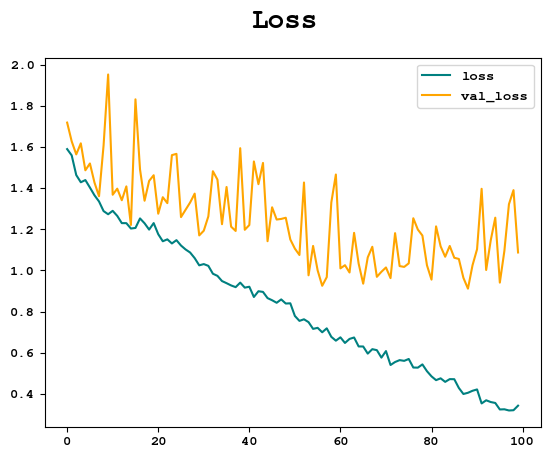

In [ ]:
font_manager.fontManager.addfont(GDRIVE["source_dir"] + "FreeMonoBold.ttf")
rcParams["font.family"] = "FreeMono"

figure = pyplot.figure()

pyplot.plot(history.history["loss"], color="teal", label="loss")
pyplot.plot(
    history.history["val_loss"],
    color="orange",
    label="val_loss"
)
figure.suptitle("Loss", fontsize=20)
pyplot.legend(loc="upper right")
pyplot.show()

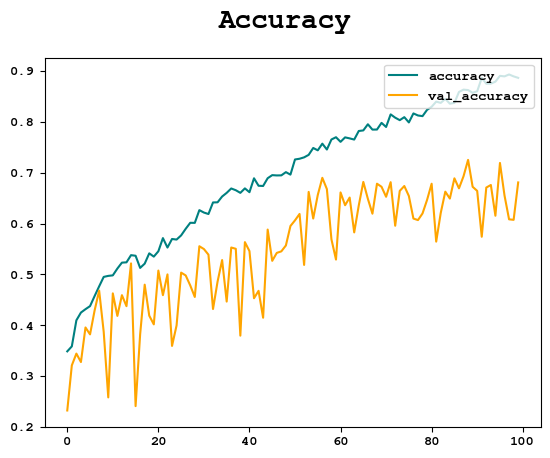

In [ ]:
figure = pyplot.figure()
pyplot.plot(history.history["accuracy"], color="teal", label="accuracy")
pyplot.plot(
    history.history["val_accuracy"],
    color="orange",
    label="val_accuracy"
)
pyplot.suptitle("Accuracy", fontsize=20)
pyplot.legend(loc="upper right")
pyplot.show()

## Predict From Images

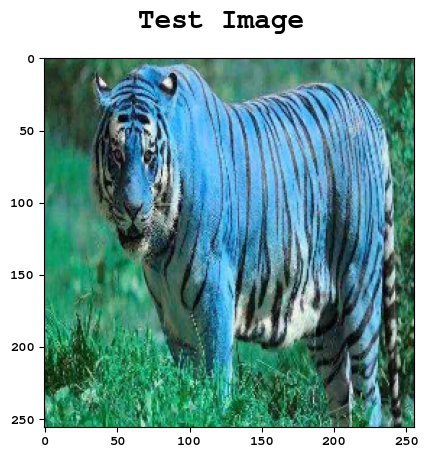


Prediction Results
bear: 1.9033333e-06
elephant: 7.616947e-05
leopard: 4.7036463e-07
lion: 0.00024134734
snake: 6.643371e-07
tiger: 0.99967945


In [ ]:
image = resize(imread(DATASET_DIR + "tiger/1200.jpg"), (256,256))
pyplot.imshow(image.numpy().astype(int))
pyplot.suptitle("Test Image", fontsize=20)
pyplot.show()

result = model.predict(expand_dims(image / 255, 0), verbose=0)

print("\n\033[37;01mPrediction Results\033[00m")
for index in range(CLASSES):
    print(labels[index], result[0][index], sep=": ")

## Save the Model

In [ ]:
model.save(GDRIVE["source_dir"] + "model.h5")

## Conversion to TFLite

In [ ]:
converter = tensorflow.lite.TFLiteConverter.from_keras_model(
    load_model(GDRIVE["source_dir"] + "model.h5")
)
tflite_model = converter.convert()

open(GDRIVE["source_dir"] + "model.tflite", "wb").write(tflite_model)